In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import plotly.express as px
from matplotlib.lines import Line2D

In [4]:
df = pd.read_csv("UFO_scrubbed.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# Check for percentage of null values
df.isnull().sum()/df.shape[0] * 100

datetime                 0.000000
city                     0.000000
state                    7.216302
country                 12.037544
shape                    2.405019
duration (seconds)       0.000000
duration (hours/min)     0.000000
comments                 0.018673
date posted              0.000000
latitude                 0.000000
longitude                0.000000
dtype: float64

In [6]:
# Drop this column as we already have duration in seconds
df = df.drop(['duration (hours/min)'], axis=1)

# Rename to remove extra space
df.rename(columns = {'longitude ':'longitude'}, inplace = True)

# Convert data to 00:00 format to avoid error
df.datetime = df.datetime.map(lambda x: "00:00" if "24:00" in x else x )
df['datetime'] =  pd.to_datetime(df['datetime'])

df['date posted'] =  pd.to_datetime(df['date posted'])

# Convert to numeric form 
df['duration (seconds)'] = pd.to_numeric(df['duration (seconds)'], errors='coerce')
df['latitude'] =  pd.to_numeric(df['latitude'], errors='coerce')

# Drop duplicated
df.drop_duplicates(inplace=True)

# Add year column for additional analysis
df['year'] = df['datetime'].dt.year

# Which location has the most UFO sightings ?
## First let us analyse which country has the most UFO sightings.

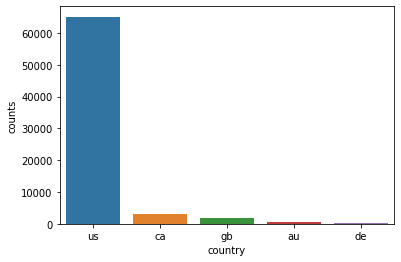

In [7]:
count_by_country = df['country'].value_counts().rename_axis('country').reset_index(name='counts')
sns.barplot(x = 'country', y = 'counts', data = count_by_country)
plt.rcParams["figure.figsize"] = (10,4)
plt.show()

In [8]:
df[df['country'] == 'us'].shape[0]/df.shape[0]

0.8105564546246732

### From the above plot it is clear thar USA has the most UFO sightings. The data from other countries is negligible in comparison to other countries. Hence lets focus our atention to USA.

In [9]:
# Filter out data corresponding to USA
us_data = df[df['country']=="us"]
us_data = us_data.drop(['country'], axis=1)
us_data['state'] = us_data['state'].str.upper() 


### Let us see which state in the US has the most UFO sightings.

In [10]:
state_data = us_data['state'].value_counts().rename_axis('state').reset_index(name='counts')
fig = px.choropleth(state_data,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='counts',
                    color_continuous_scale="Viridis_r")
fig.show()

### California has more than double the UFO sightings of any other state in the US.

# Is there any relation between the movies based on aliens and UFO sightings?

### Let us use the [List of films featuring extraterrestrials](https://en.wikipedia.org/wiki/List_of_films_featuring_extraterrestrials) data from wikipedia to see the number of films released each year and its releation to the USO sightings each year.

In [11]:
movies_df = pd.read_csv("alien_movies.csv")
movies_by_year = movies_df['Year'].value_counts().rename_axis('year').reset_index(name='count of movies')
sightings_by_year = df['year'].value_counts().rename_axis('year').reset_index(name='count of sightings')

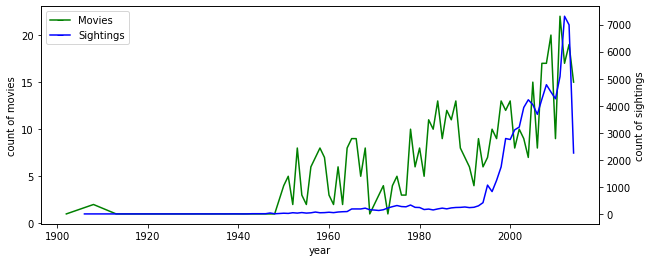

In [12]:
# Plot line plots for movies and ufo sightings by year
ax = sns.lineplot(x = 'year', y = 'count of movies', data = movies_by_year[movies_by_year['year'] < 2015], color="g")
ax2 = ax.twinx()
sns.lineplot(x = 'year', y = 'count of sightings', data = sightings_by_year[sightings_by_year['year'] < 2015], color="b", ax=ax2)
ax.legend(handles=[Line2D([], [], marker='_', color="g", label='Movies'), Line2D([], [], marker='_', color="b", label='Sightings')])
plt.rcParams["figure.figsize"] = (10,4)
plt.show()

# What time during the day do we see the most UFO sightings?

In [16]:
# Add a new column which tells us at what time of the day the ufo was spotted

# add an 'hour' column which will be used to create bins
us_data['hour'] = us_data['datetime'].dt.hour

# create a new 'day_time' column which divides the daytime column to bins
hour_bins = [0,4,8,12,16,20,24]
day_labels = ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']
us_data['day_time'] = pd.cut(us_data['hour'], bins=hour_bins, labels=day_labels, include_lowest=True)

# drop the hour dataset as it is no longer needed
us_data = us_data.drop(['hour'], axis=1)

### Let us see at what time there are maximum UFO sightings.

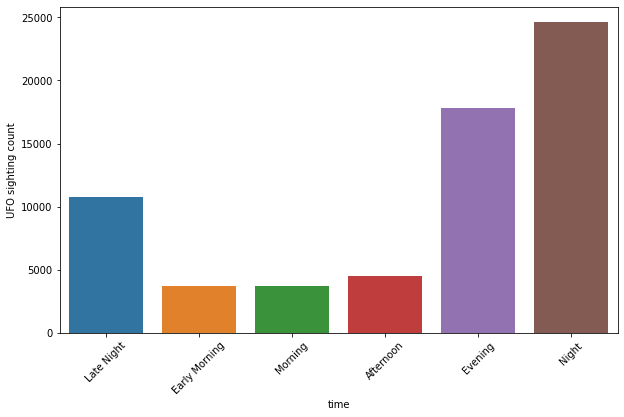

In [22]:
day_counts = us_data['day_time'].value_counts().rename_axis('time').reset_index(name='UFO sighting count')
sns.barplot(x = 'time', y = 'UFO sighting count', data = day_counts)
plt.rcParams["figure.figsize"] = (5,3)
plt.xticks(rotation=45)
plt.show()

From the above plot, we see that maximum UFO sightings are recorded when it is dark i.e. there is less or no sunlight.

# Does the shape reported depend on what time of the day it is spotted?

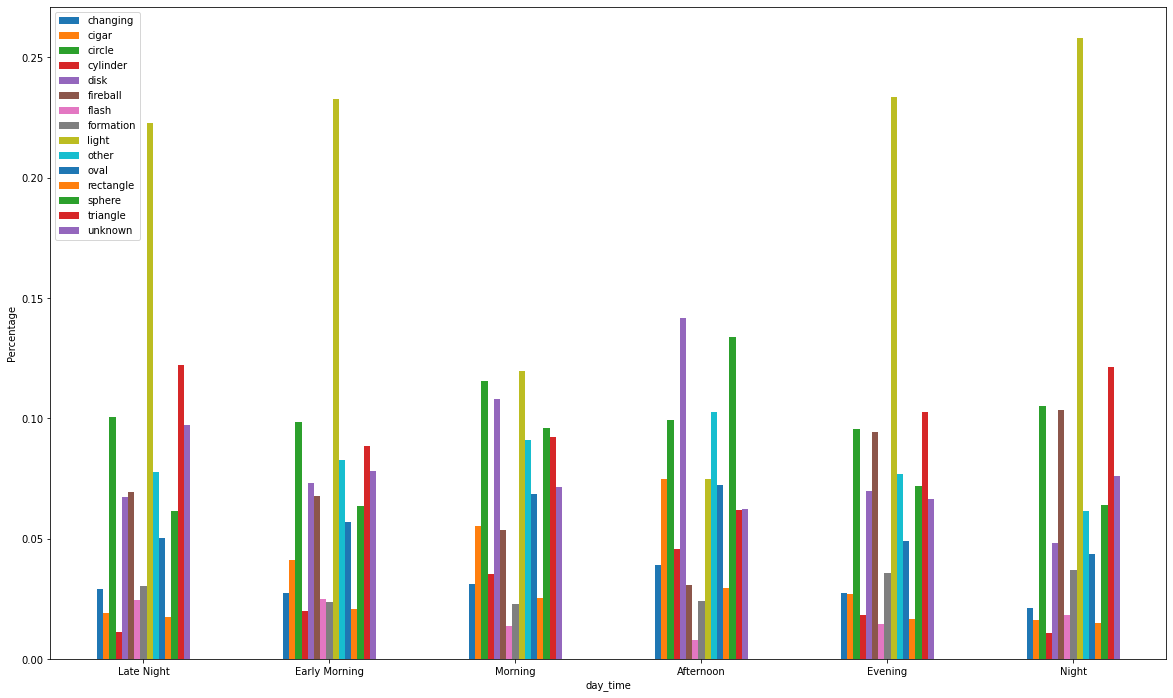

In [28]:
# Create a time dataframe that counts the occurances of various shapes at the given time
time_df = us_data[['shape', 'day_time']]
time_df = pd.get_dummies(time_df, columns = ['shape'], prefix='', prefix_sep='').groupby('day_time').sum()
# Select shape that are spotted over 1000 times
time_df = time_df[time_df.columns[time_df.sum() > 1000]]
# Convert each row values to percentage for better visualization 
time_df = time_df.div(time_df.sum(axis=1), axis=0)
# Barplot all the columns
time_df.plot(kind='bar', rot=0)
plt.ylabel("Percentage")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

### From the above plot, we can see that 'light' shape is reported the highest for 'Late Night', 'Early Morning', 'Evening' and 'Night', whereas it reduces drastically for 'Morning' and 'Afternoon'. This leads to the conclusion that when it is dark, the reported UFO reported is some illuminating object whereas when there is sunlight, the reported object has shape like 'sphere', 'circle', 'disk' etc.